
最近跑了Kaggle中的Titanic竞赛

参考了一些博客
附上链接：
- https://www.jianshu.com/p/e79a8c41cb1a
- https://www.kesci.com/home/project/5bfe39b3954d6e0010681cd1

博客内容大多数都差不多，参考了一下总体思路，在这些博客的基础上做了优化
比如：
1. 对Name属性进行了挖掘
2. 用seaborn绘图更直观
3. 做了模型融合（但是效果一般）
4. 进行了参数调优

*Titanic简介：*

根据年龄，性别或船上乘客舱位等特征来预测给定乘客的生存或死亡。


结果：本文在公共排行榜上最高获得了0.79904的准确性得分，排名前11％。


Talk is cheap,show me the code!

方便图片显示，用html的使绘图集中(主要还是因为jupyter notebook)

In [341]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

导入基本的库

In [342]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 100

from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns

import pylab as plot
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plot.rcParams.update(params)

先加载训练集。

In [343]:
data = pd.read_csv('train.csv')

# 一、Data Insights
 这是第一部分也是最重要的一部分，很大程度的决定了后面的Feature Engineering 和 Modeling 应该怎么做。
 只有足够了解数据才能做出好的效果！！

In [344]:
print (data.shape)

(891, 12)


训练集的shape
- 891 rows
- 12 columns


先简单的查看一下数据

In [345]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survived列是**目标变量**。如果Suvived = 1，则该乘客幸免，否则死亡。是我们要预测的变量。

其他变量描述了乘客。它们是**特征**。

- PassengerId：和给船上每个旅客的编号
- Pclass：乘客舱。它具有三个可能的值：1,2,3（第一，第二和第三等）
- Name:名字
- Sex:性别
- Age:年龄
- SibSp：与乘客同行的兄弟姐妹和配偶的数量
- Parch：与乘客同行的父母和子女的数量
- Ticket:票号
- Fare:票价
- Cabin:舱号
- Embarked:人们登上泰坦尼克号的三个可能区域。三个可能的值S，C，Q

进一步查看一下数据

In [346]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



可以看出Age列中缺少177个值。

在这里先用中位数代替空值，方便后面画图，只用中位数来代替肯定不准确（后面会用具体算法来填充空值）。

In [347]:
data['Age'] = data['Age'].fillna(data['Age'].median())

看看处理后的

In [348]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


我们先来画图，看看能从数据中看出啥

先看看性别和存活与否的关系。

In [349]:
data['Died'] = 1 - data['Survived']

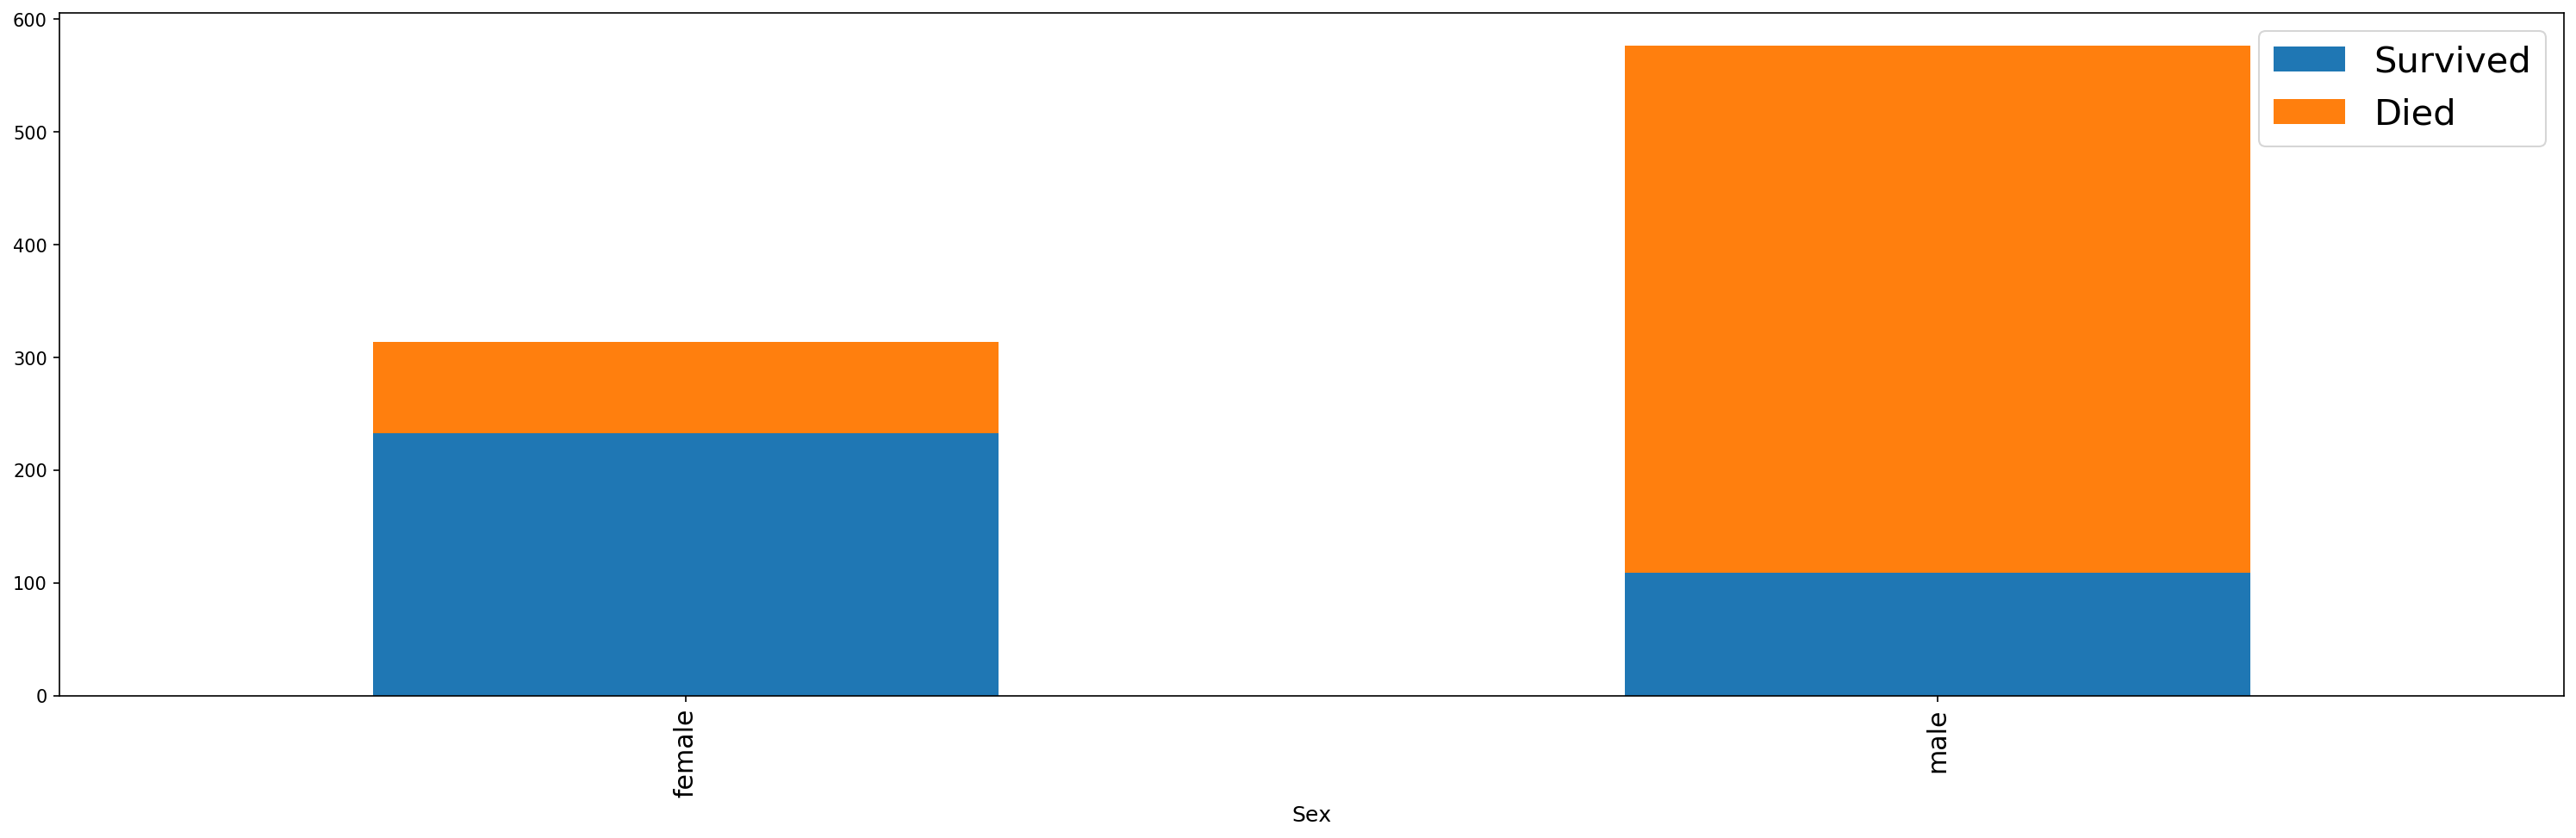

In [350]:
data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True);

![energy](./images/article_1/1.png)

看起来男性更容易遇难，女性更容易获救。

再看看他们的比例。

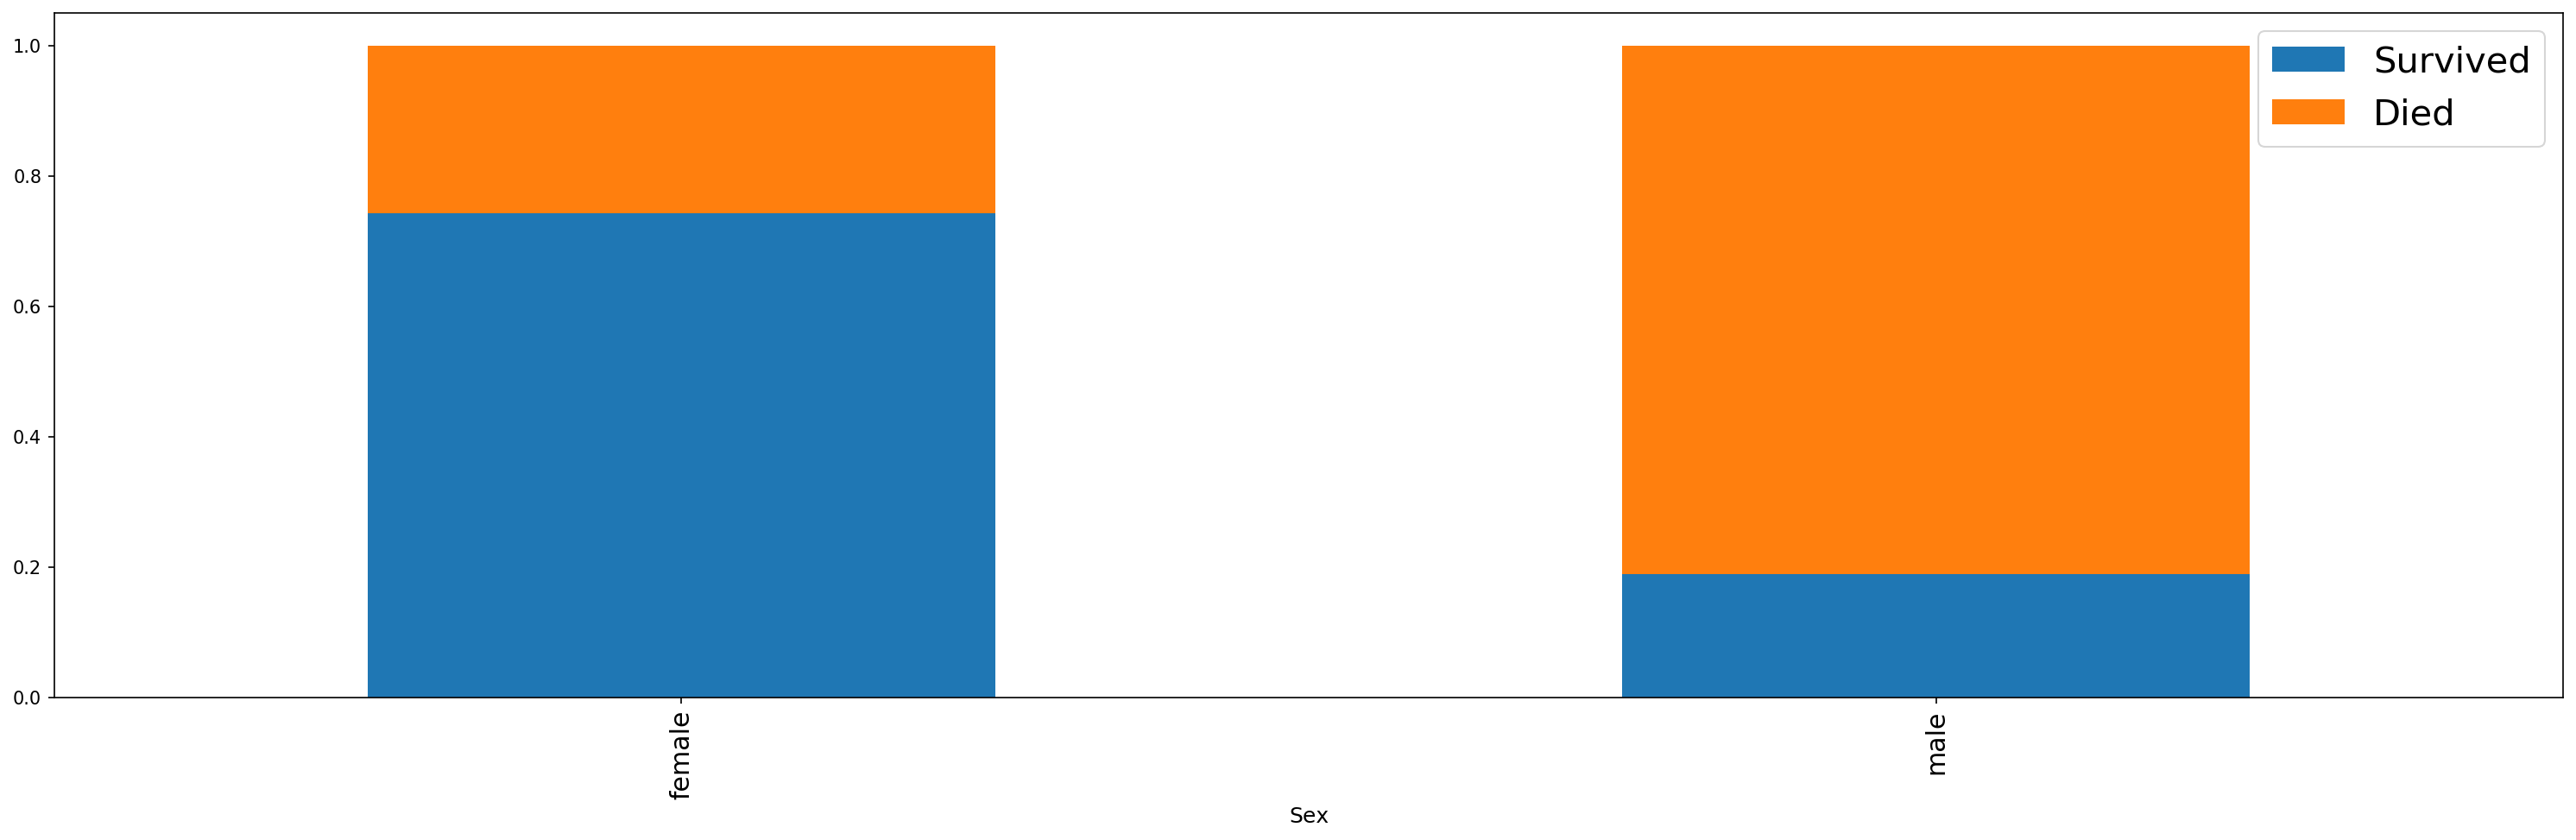

In [351]:
data.groupby('Sex').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7), 
                                                           stacked=True);

![energy](./images/article_1/2.png)

**果然在危险的时候，男性总会挺身而出。。。**

再来看看年龄吧

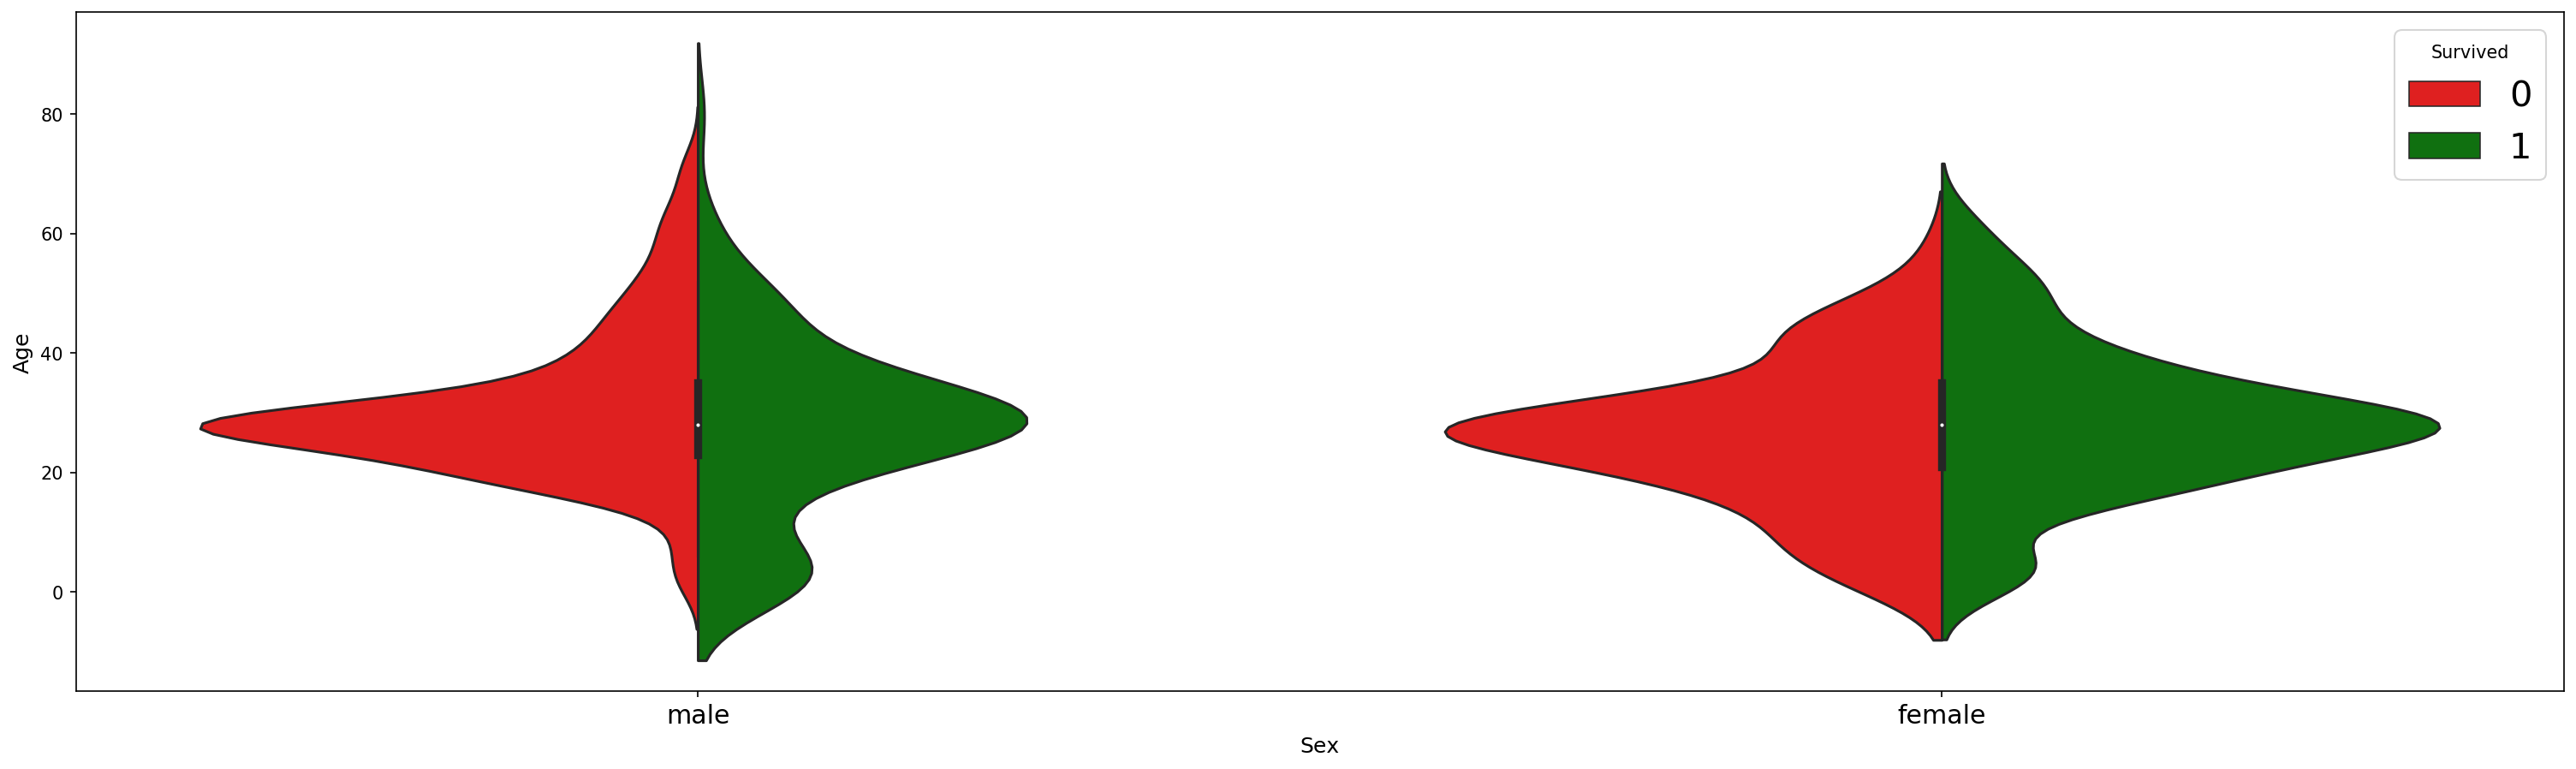

In [352]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=data, 
               split=True,
               palette={0: "r", 1: "g"}
              );

![energy](./images/article_1/3.png)

从提琴图可以看出大概是在**20-40**岁的人存活率比较高

老人和小孩都跑不动了吗。

（果然时代都掌握在青年中年人手里

再来看看票价的影响吧

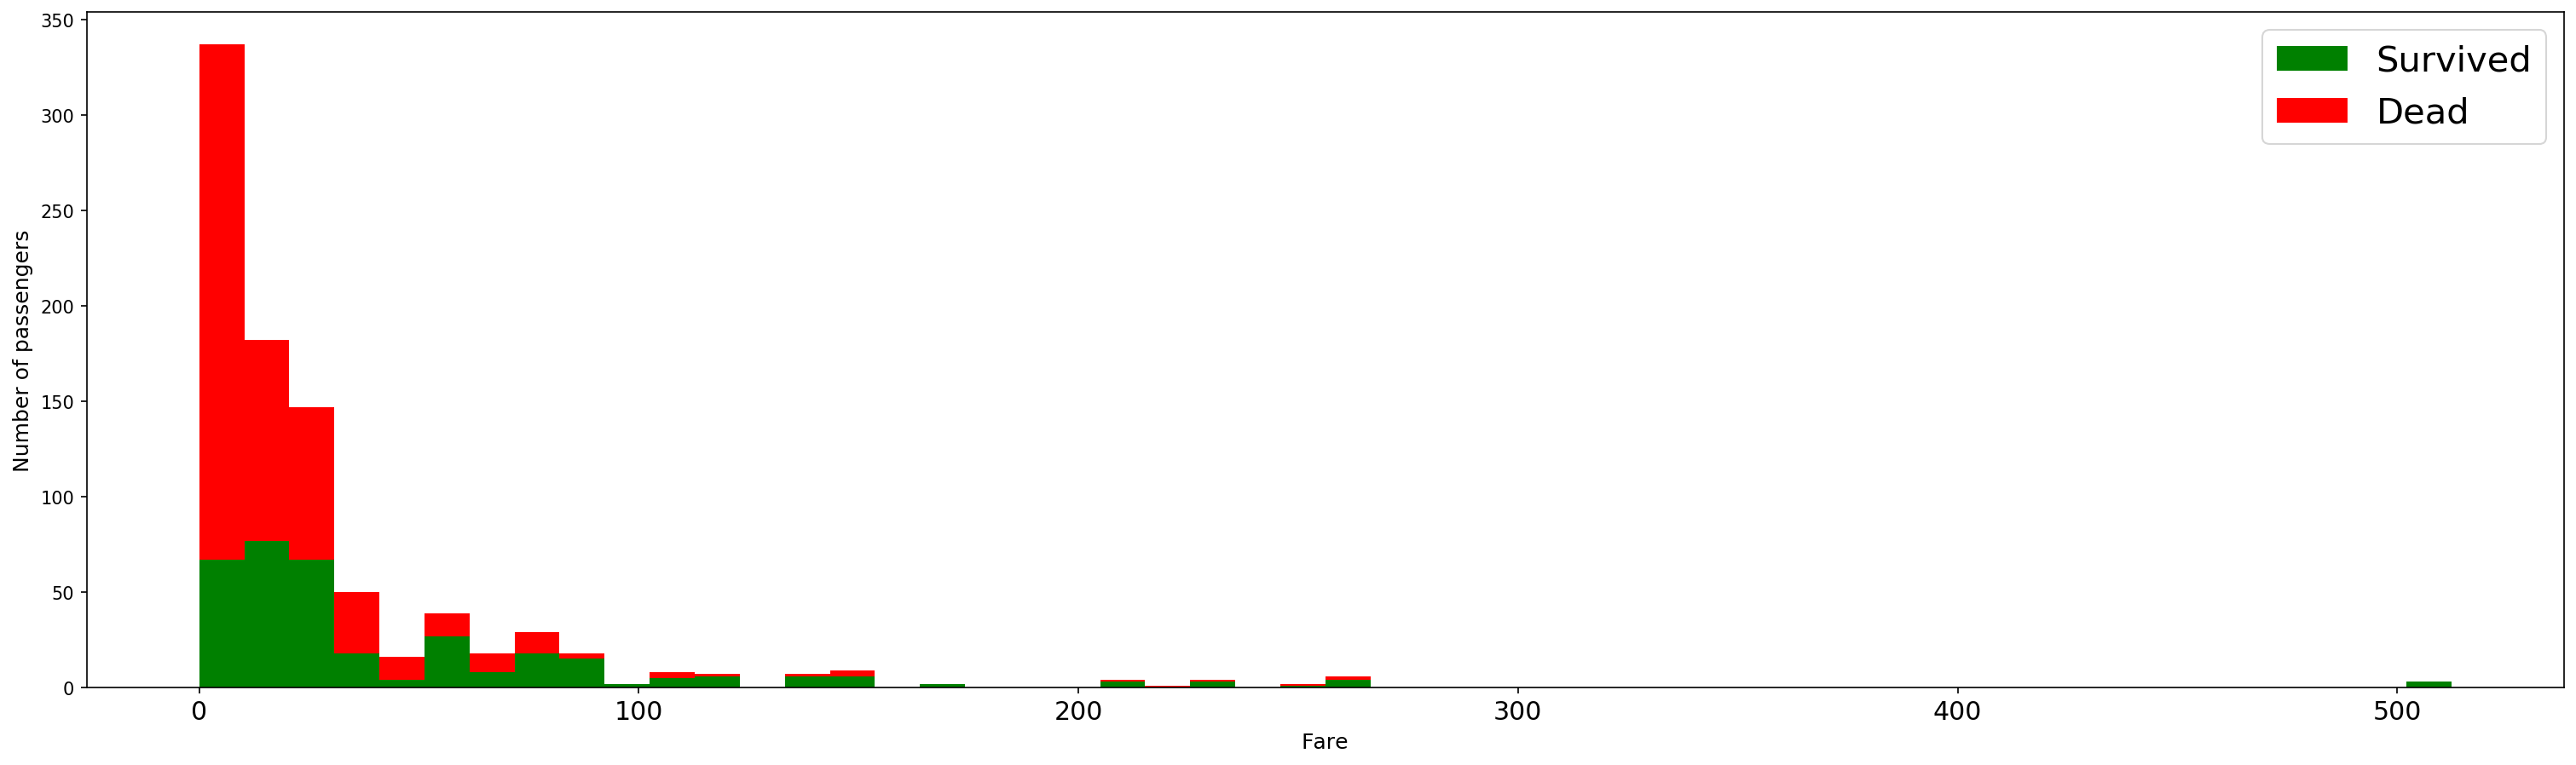

In [353]:
figure = plt.figure(figsize=(25, 7))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend();

![energy](./images/article_1/4.png)

看起来，票价高的人容易被获救，一般票价高的人可能社会地位会比较高。

不过票价高的人还是比较稀少的

（这就是贫富差距吗

让我们再综合的看一下年龄和票价

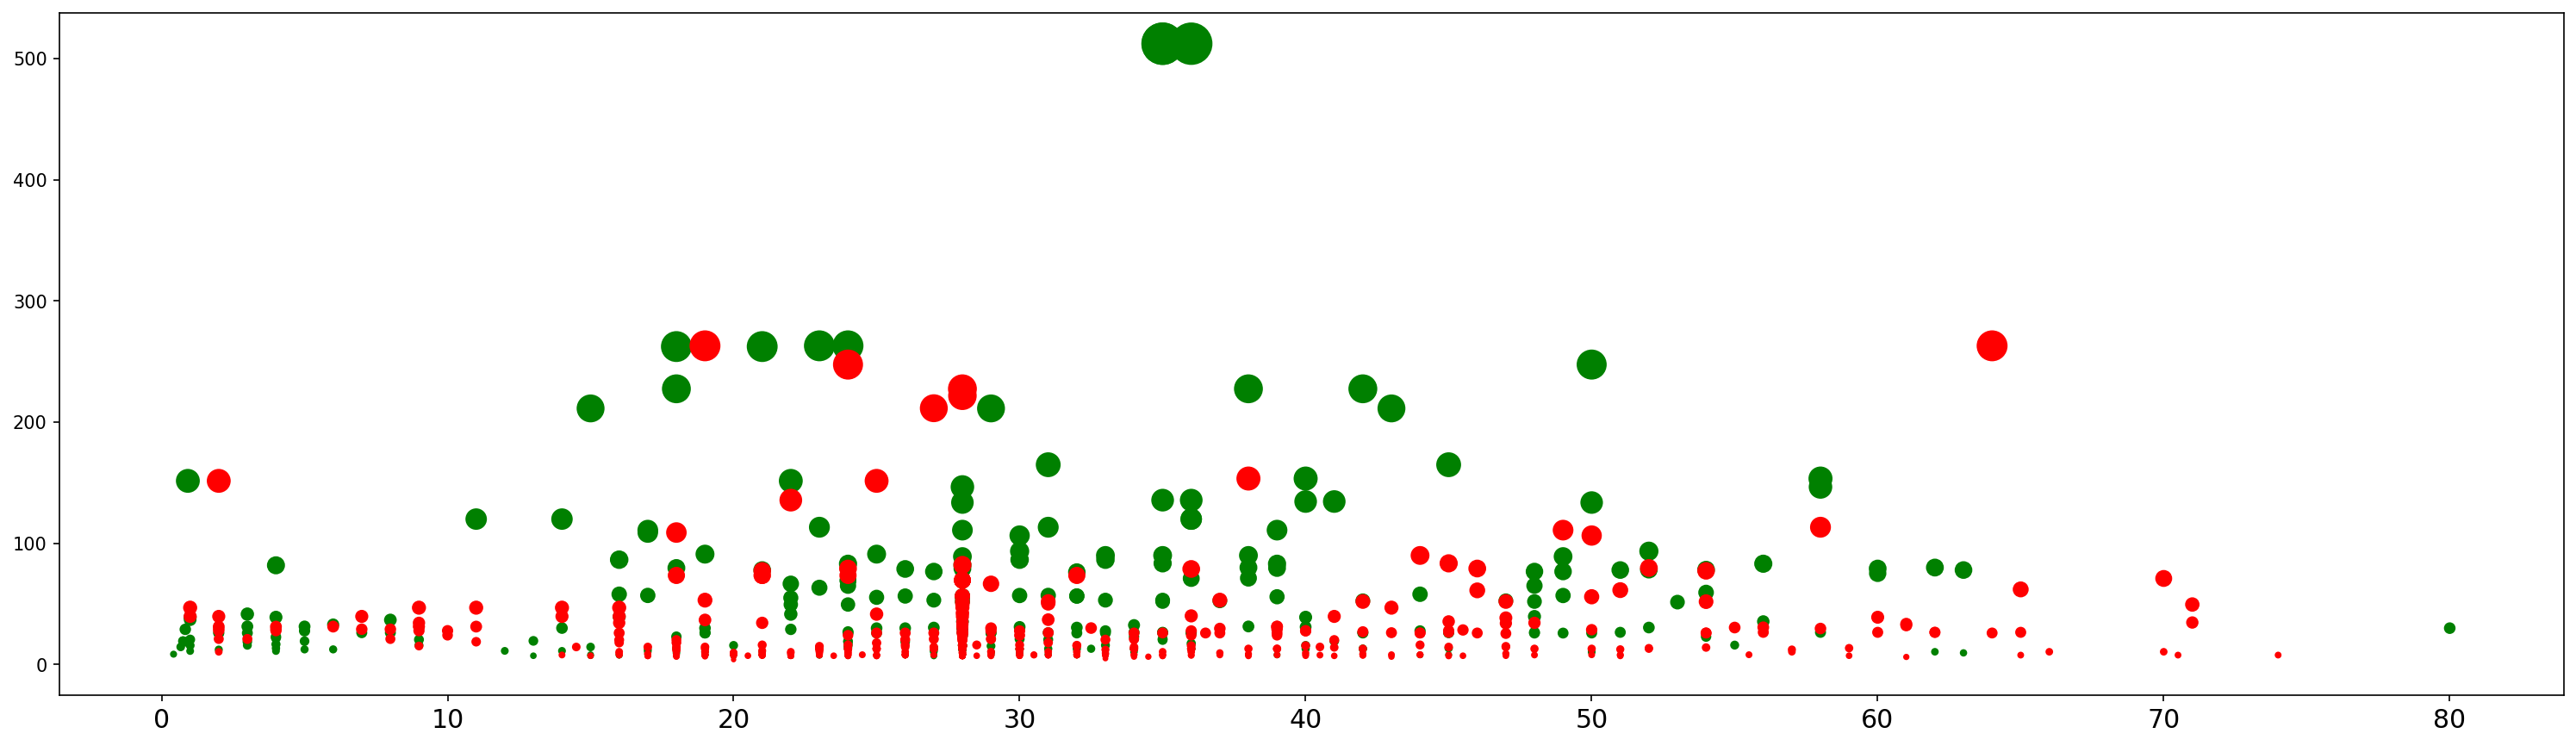

In [354]:
plt.figure(figsize=(25, 7))
ax = plt.subplot()

ax.scatter(data[data['Survived'] == 1]['Age'], data[data['Survived'] == 1]['Fare'], 
           c='green', s=data[data['Survived'] == 1]['Fare'])
ax.scatter(data[data['Survived'] == 0]['Age'], data[data['Survived'] == 0]['Fare'], 
           c='red', s=data[data['Survived'] == 0]['Fare']);

![energy](./images/article_1/5.png)

圆圈的大小与票价成正比。

x轴是年龄，y轴是票价。

我们可以观察到：

1. x = 20到x = 45之间的大绿点：成人票价最高
2. x = 10到x = 45之间的小红点，可能是船上较低阶层的成年人（穷
3. x = 0和x = 7之间的小绿点：这些是被救下来的的小孩

和常识一样，票价和阶层是成正比的

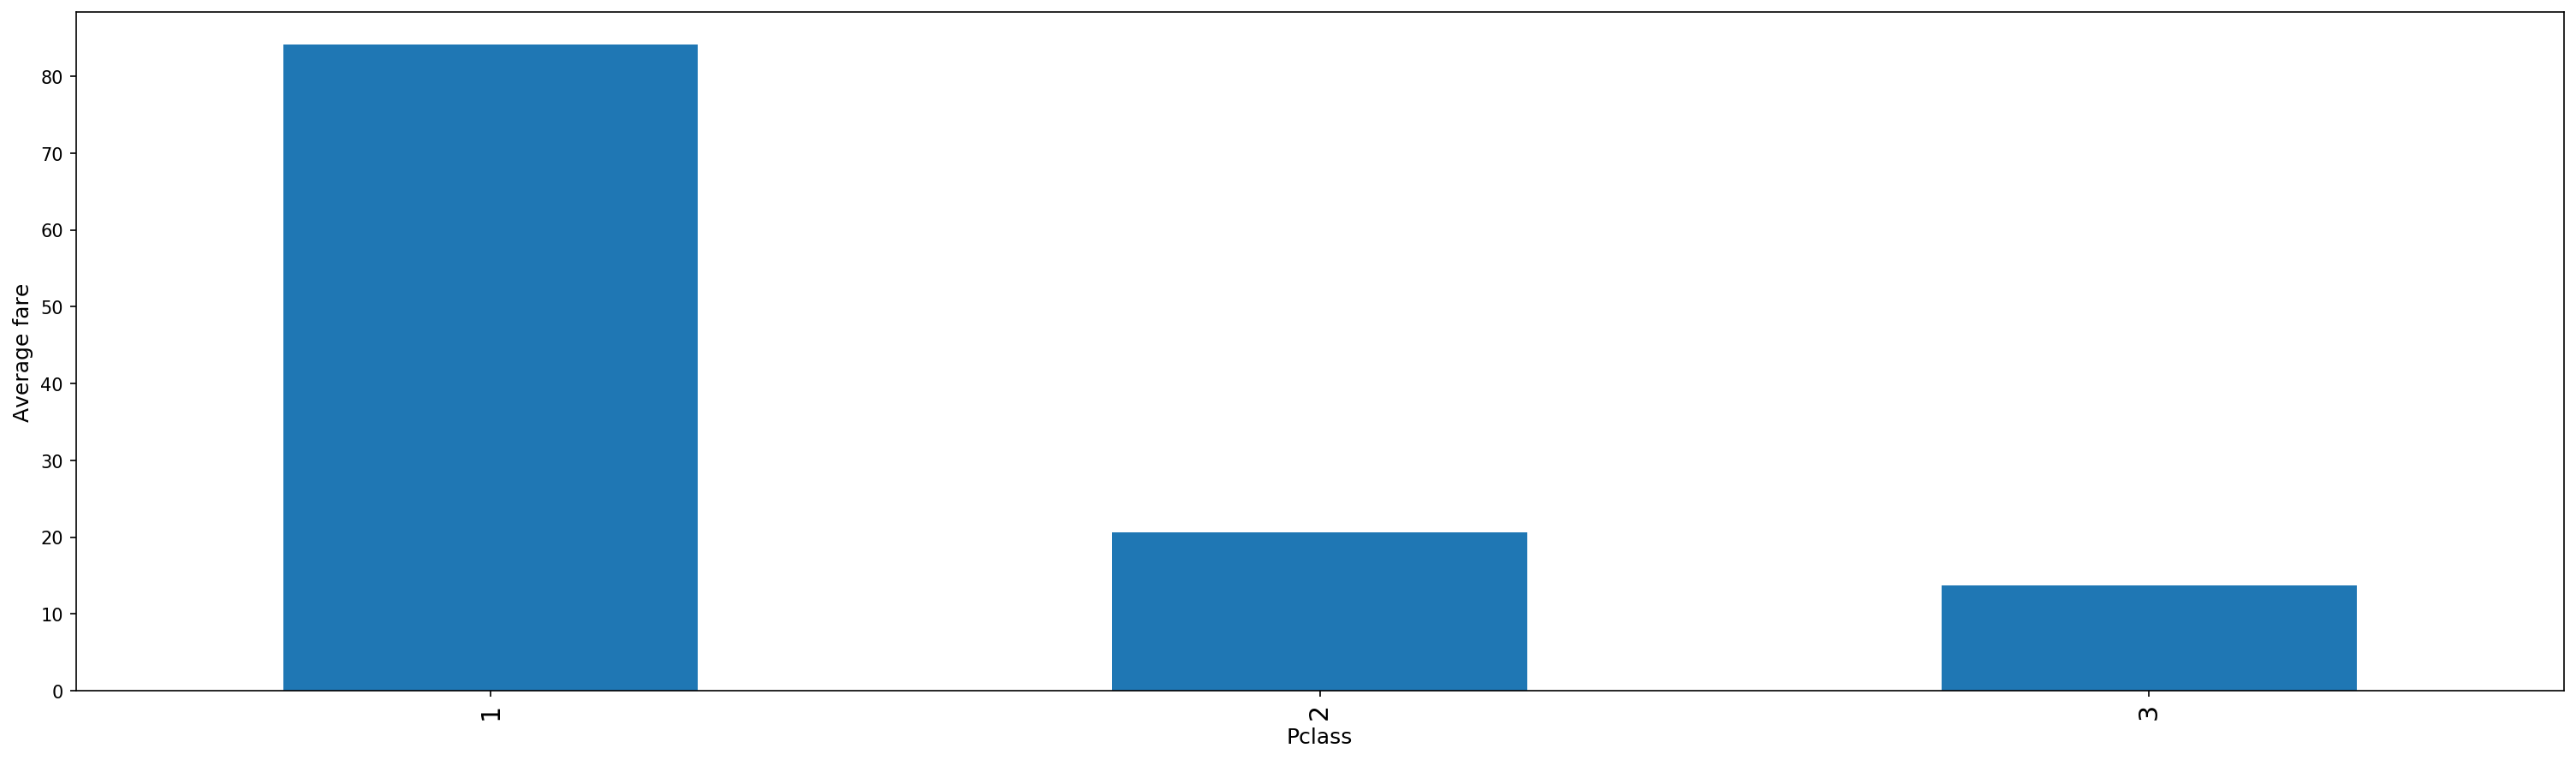

In [355]:
ax = plt.subplot()
ax.set_ylabel('Average fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(25, 7), ax = ax);

![energy](./images/article_1/6.png)

看看Embarked对存活率的影响

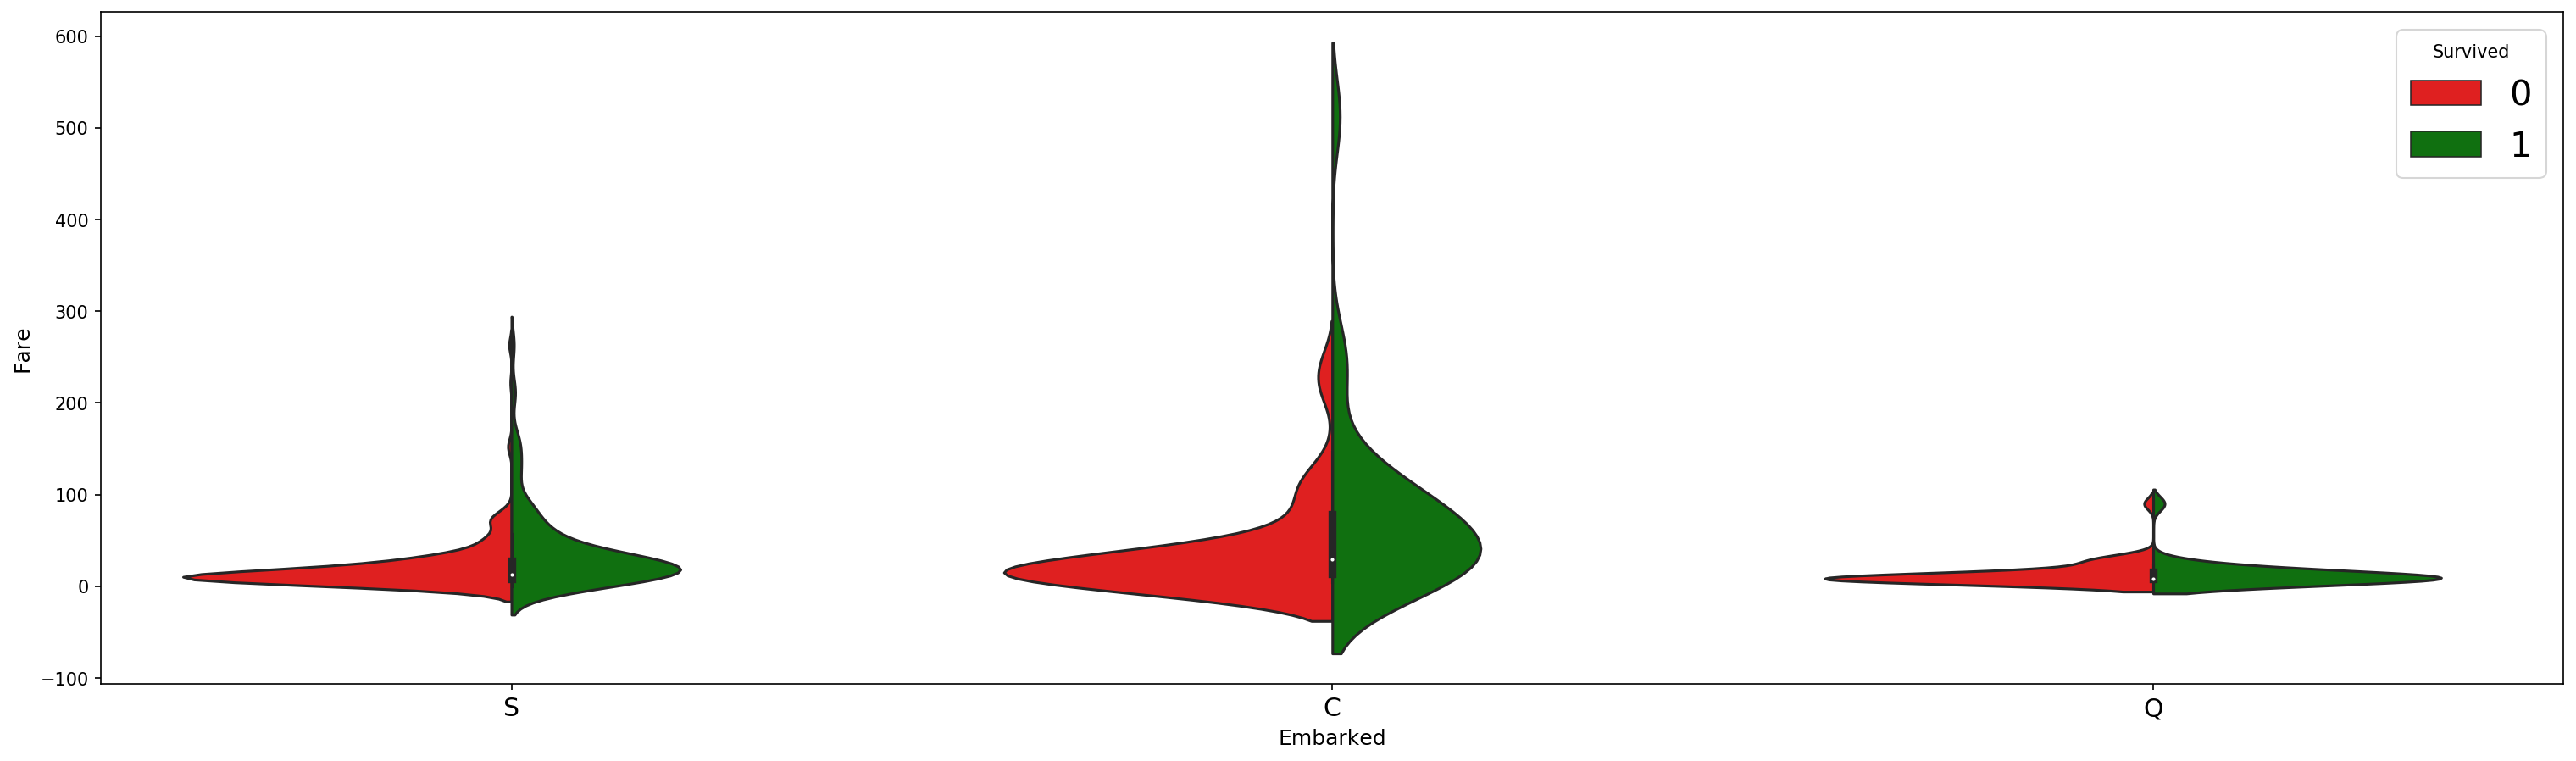

In [356]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Embarked', y='Fare', hue='Survived', data=data, split=True, palette={0: "r", 1: "g"});

![energy](./images/article_1/7.png)


Embarked C 的票价似乎范围更广，可以看出，支付最高价的乘客就是幸存者。

这种也情况发生在登船S上，但是发生在登船Q上的情况较少。

# 二  、Feature engineering


在上一部分中，我们对数据进行了探索并发现了一些有趣的相关性。

在这一部分中，我们将看到如何处理已有的特征，为后面的Modeling做准备。

为了表达更清楚，将代码分解为单独的函数。

先写个函数看看函数调用是否成功，方便看到程序走到哪了。

In [357]:
def status(feature):
    print ('Processing', feature, ': ok')

##  载入数据

这里我直接把Targets取了出来，然后把训练集和测试集放在了一起

因为后面做数据处理训练集和测试集都要做，不如先合并了。


In [358]:
def get_combined_data():
    train = pd.read_csv('train.csv')
    
    test = pd.read_csv('test.csv')
    
    targets = train.Survived
    train.drop(['Survived'], 1, inplace=True)
    
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'PassengerId'], inplace=True, axis=1)
    
    return combined

In [359]:
combined = get_combined_data()

In [360]:
print (combined.shape)

(1309, 10)


1309行，其中数据集891行，测试集418行

In [361]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



## Name的处理
大多数人都以为Name名字这一列没有啥用。

但是如果仔细观察：

- Braund, Mr. Owen Harris 中的 Mr
- Heikkinen, Miss. Laina  中的Miss
等等

您会注意到每个名称中都有Title！这可以是简单的小姐或太太，但有时也可以是更复杂的东西，例如Master(硕士或者大师)，Duke（爵士）或Dona。在这种情况下，我们可以通过简单地解析名称并提取Title并将其转换为二进制变量来引入有关社会地位的其他信息。

让我们先看看有哪些标题

In [362]:
titles = set()
for name in data['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

In [363]:
print (titles)

{'Rev', 'Jonkheer', 'Mrs', 'Master', 'Col', 'the Countess', 'Don', 'Mr', 'Major', 'Lady', 'Sir', 'Mlle', 'Capt', 'Dr', 'Miss', 'Mme', 'Ms'}


In [364]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    combined['Title'] = combined.Title.map(Title_Dictionary)
    status('Title')
    return combined

我们把这些Title都映射到下列的总Title：

- Officer
- Royalty 
- Mr
- Mrs
- Miss
- Master


In [365]:
combined = get_titles()

Processing Title : ok


In [366]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


看看我们总结的Title有没有添加成功（在最后呢

In [367]:
combined[combined['Title'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C,NaN


发现有一个空值，但是他在测试集影响不大，不管它了。

## Fare的处理

把之前发现的Fare中的一个缺值用均值代替(其实是后面做随机森林的时候报错才发现的。。。。。这里先把他写到前面

In [368]:
def process_fares():
    global combined
    combined.Fare.fillna(combined.iloc[:891].Fare.mean(), inplace=True)
    status('fare')
    return combined

In [369]:
combined = process_fares()

Processing fare : ok



## Age的处理

我们在第一部分中看到训练集Age变量缺少177个值。这是一个很大的数字（约占数据集的13％）。用
年龄平均数或中位数年龄代替他们可能不是最好的解决方案，因为年龄可能因乘客的群体和类别而异。


训练集里丢失的Age

In [370]:
print (combined.iloc[:891].Age.isnull().sum())

177


测试集里丢失的Age

In [371]:
print (combined.iloc[891:].Age.isnull().sum())

86


我这里用用随机森林的方法来补充年龄的缺值

用'Fare', 'Parch', 'SibSp', 'Pclass'这几个特征来对Age进行预测并填充

函数如下

In [372]:
from sklearn.ensemble import RandomForestRegressor

def process_age(df):
    
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
    known_age = age_df[age_df.Age.notnull()].iloc[:,:].values
    unknown_age = age_df[age_df.Age.isnull()].iloc[:,:].values

    y = known_age[:, 0]

    X = known_age[:, 1:]

    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    
    predictedAges = rfr.predict(unknown_age[:, 1::])
    
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    status("Age")
    
    return df

In [373]:
combined = process_age(combined)

Processing Age : ok



这里如果报错：*Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required*.

不是代码的问题，是jupyter notebook变量缓冲的问题

解决方法：
1. 重新运行上面两个代码块即可
2. 刷新或者重新打开，从头开始运行一遍
3. 直接参考[titanic.py](https://github.com/Supltz/Kaggle_Titanic/blob/master/titanic.py)吧 

我们发现“Embarked”中有两个缺失值，而Cabin中有很多缺失值。稍后我们将回到这些特征。

我们先把名字做一个one_hot编码

In [374]:
def process_names():
    global combined
    combined.drop('Name', axis=1, inplace=True)
    
    titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
    combined = pd.concat([combined, titles_dummies], axis=1)
    
    combined.drop('Title', axis=1, inplace=True)
    
    status('names')
    return combined

In [375]:
combined = process_names()

Processing names : ok


In [376]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,0


one_hot 编码成功

## Embarked的处理

In [377]:
def process_embarked():
    global combined
    combined.Embarked.fillna('S', inplace=True)
    embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
    combined = pd.concat([combined, embarked_dummies], axis=1)
    combined.drop('Embarked', axis=1, inplace=True)
    status('embarked')
    return combined

对两个缺失的，用众数代替，然后做one_hot

In [378]:
combined = process_embarked()

Processing embarked : ok


In [379]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,C85,0,0,0,1,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,C123,0,0,0,1,0,0,0,0,1
4,3,male,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,0,0,0,1


## Cabin的处理

In [380]:
train_cabin, test_cabin = set(), set()

for c in combined.iloc[:891]['Cabin']:
    try:
        train_cabin.add(c[0])
    except:
        train_cabin.add('U')
        
for c in combined.iloc[891:]['Cabin']:
    try:
        test_cabin.add(c[0])
    except:
        test_cabin.add('U')

In [381]:
print (train_cabin)

{'T', 'A', 'G', 'B', 'F', 'C', 'E', 'U', 'D'}


In [382]:
print (test_cabin)

{'A', 'G', 'B', 'F', 'E', 'C', 'U', 'D'}


很好，测试集的cabin在训练集都有。


In [383]:
def process_cabin():
    global combined 
    combined.Cabin.fillna('U', inplace=True)
    
    combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])
    
    cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
    combined = pd.concat([combined, cabin_dummies], axis=1)

    combined.drop('Cabin', axis=1, inplace=True)
    status('cabin')
    return combined

用第一个字母来代表Cabin U来代表Unkown，继续做one_hot 编码

In [384]:
combined = process_cabin()

Processing cabin : ok


### 到目前这个数据集终于没有缺失的值了！

In [385]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,male,22.0,1,0,A/5 21171,7.2500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,3,male,35.0,0,0,373450,8.0500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


## Sex的 处理

In [386]:
def process_sex():
    global combined
    combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})
    status('Sex')
    return combined

用0，1表示性别。。。。

In [387]:
combined = process_sex()

Processing Sex : ok


## Pclass的处理

In [388]:
def process_pclass():
    
    global combined
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")
    
    combined = pd.concat([combined, pclass_dummies],axis=1)
    
    combined.drop('Pclass',axis=1,inplace=True)
    
    status('Pclass')
    return combined

还是做one_hot 编码

In [389]:
combined = process_pclass()

Processing Pclass : ok


## Ticket的处理

取出票名的前缀

In [390]:
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

In [391]:
tickets = set()
for t in combined['Ticket']:
    tickets.add(cleanTicket(t))

In [392]:
print (len(tickets))

37


In [393]:
def process_ticket():
    
    global combined
    
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip(), ticket)
        ticket = list(filter(lambda t : not t.isdigit(), ticket))
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'
    

    # Extracting dummy variables from tickets:

    combined['Ticket'] = combined['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
    combined = pd.concat([combined, tickets_dummies], axis=1)
    combined.drop('Ticket', inplace=True, axis=1)

    status('Ticket')
    return combined

In [394]:
combined = process_ticket()

Processing Ticket : ok


## Family的处理

这里根据家庭的大小来分类

这是非常合理的

大家庭聚在一起，因此与独自旅行的人相比，他们更有可能得到救助。

In [395]:
def process_family():
    
    global combined
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    status('family')
    return combined

创建了4个新的特征：

- FamilySize : 家庭大小
- Sigleton : 是不是独自一人
- SmallFamily : 小家庭 2 <= size <= 4
- LargeFamily : 大家庭5 < size

In [396]:
combined = process_family()

Processing family : ok


In [397]:
print (combined.shape)

(1309, 67)


这样总共搞出来67列。。。。这也太多了

In [398]:
combined.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,1,0
4,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0


# 三、Modeling

终于来到建模啦

在这一部分中，我们根据创建的功能使用对乘客的了解，然后建立统计模型。您可以将这种模型视为一个可以处理任何新乘客信息并确定他是否能够幸存的盒子。

先引入一些建模需要的库

In [399]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

这里采用 5-fold cross validation 

In [400]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

之前数据处理完了，就可以将训练集和测试集分开啦

In [401]:
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv('train.csv', usecols=['Survived'])['Survived'].values
    train = combined.iloc[:891]
    test = combined.iloc[891:]
    
    return train, test, targets

In [402]:
train, test, targets = recover_train_test_target()

## Feature的选择


到目前为止，我们已经创造了67列。这个数字很大。

我们必须从中筛选有用的，影响比较大的特征来：

- 减少数据之间的冗余
- 加快了训练过程
- 减少过拟合

我们可以先来看看哪一些特征是重要的

In [403]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

In [404]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

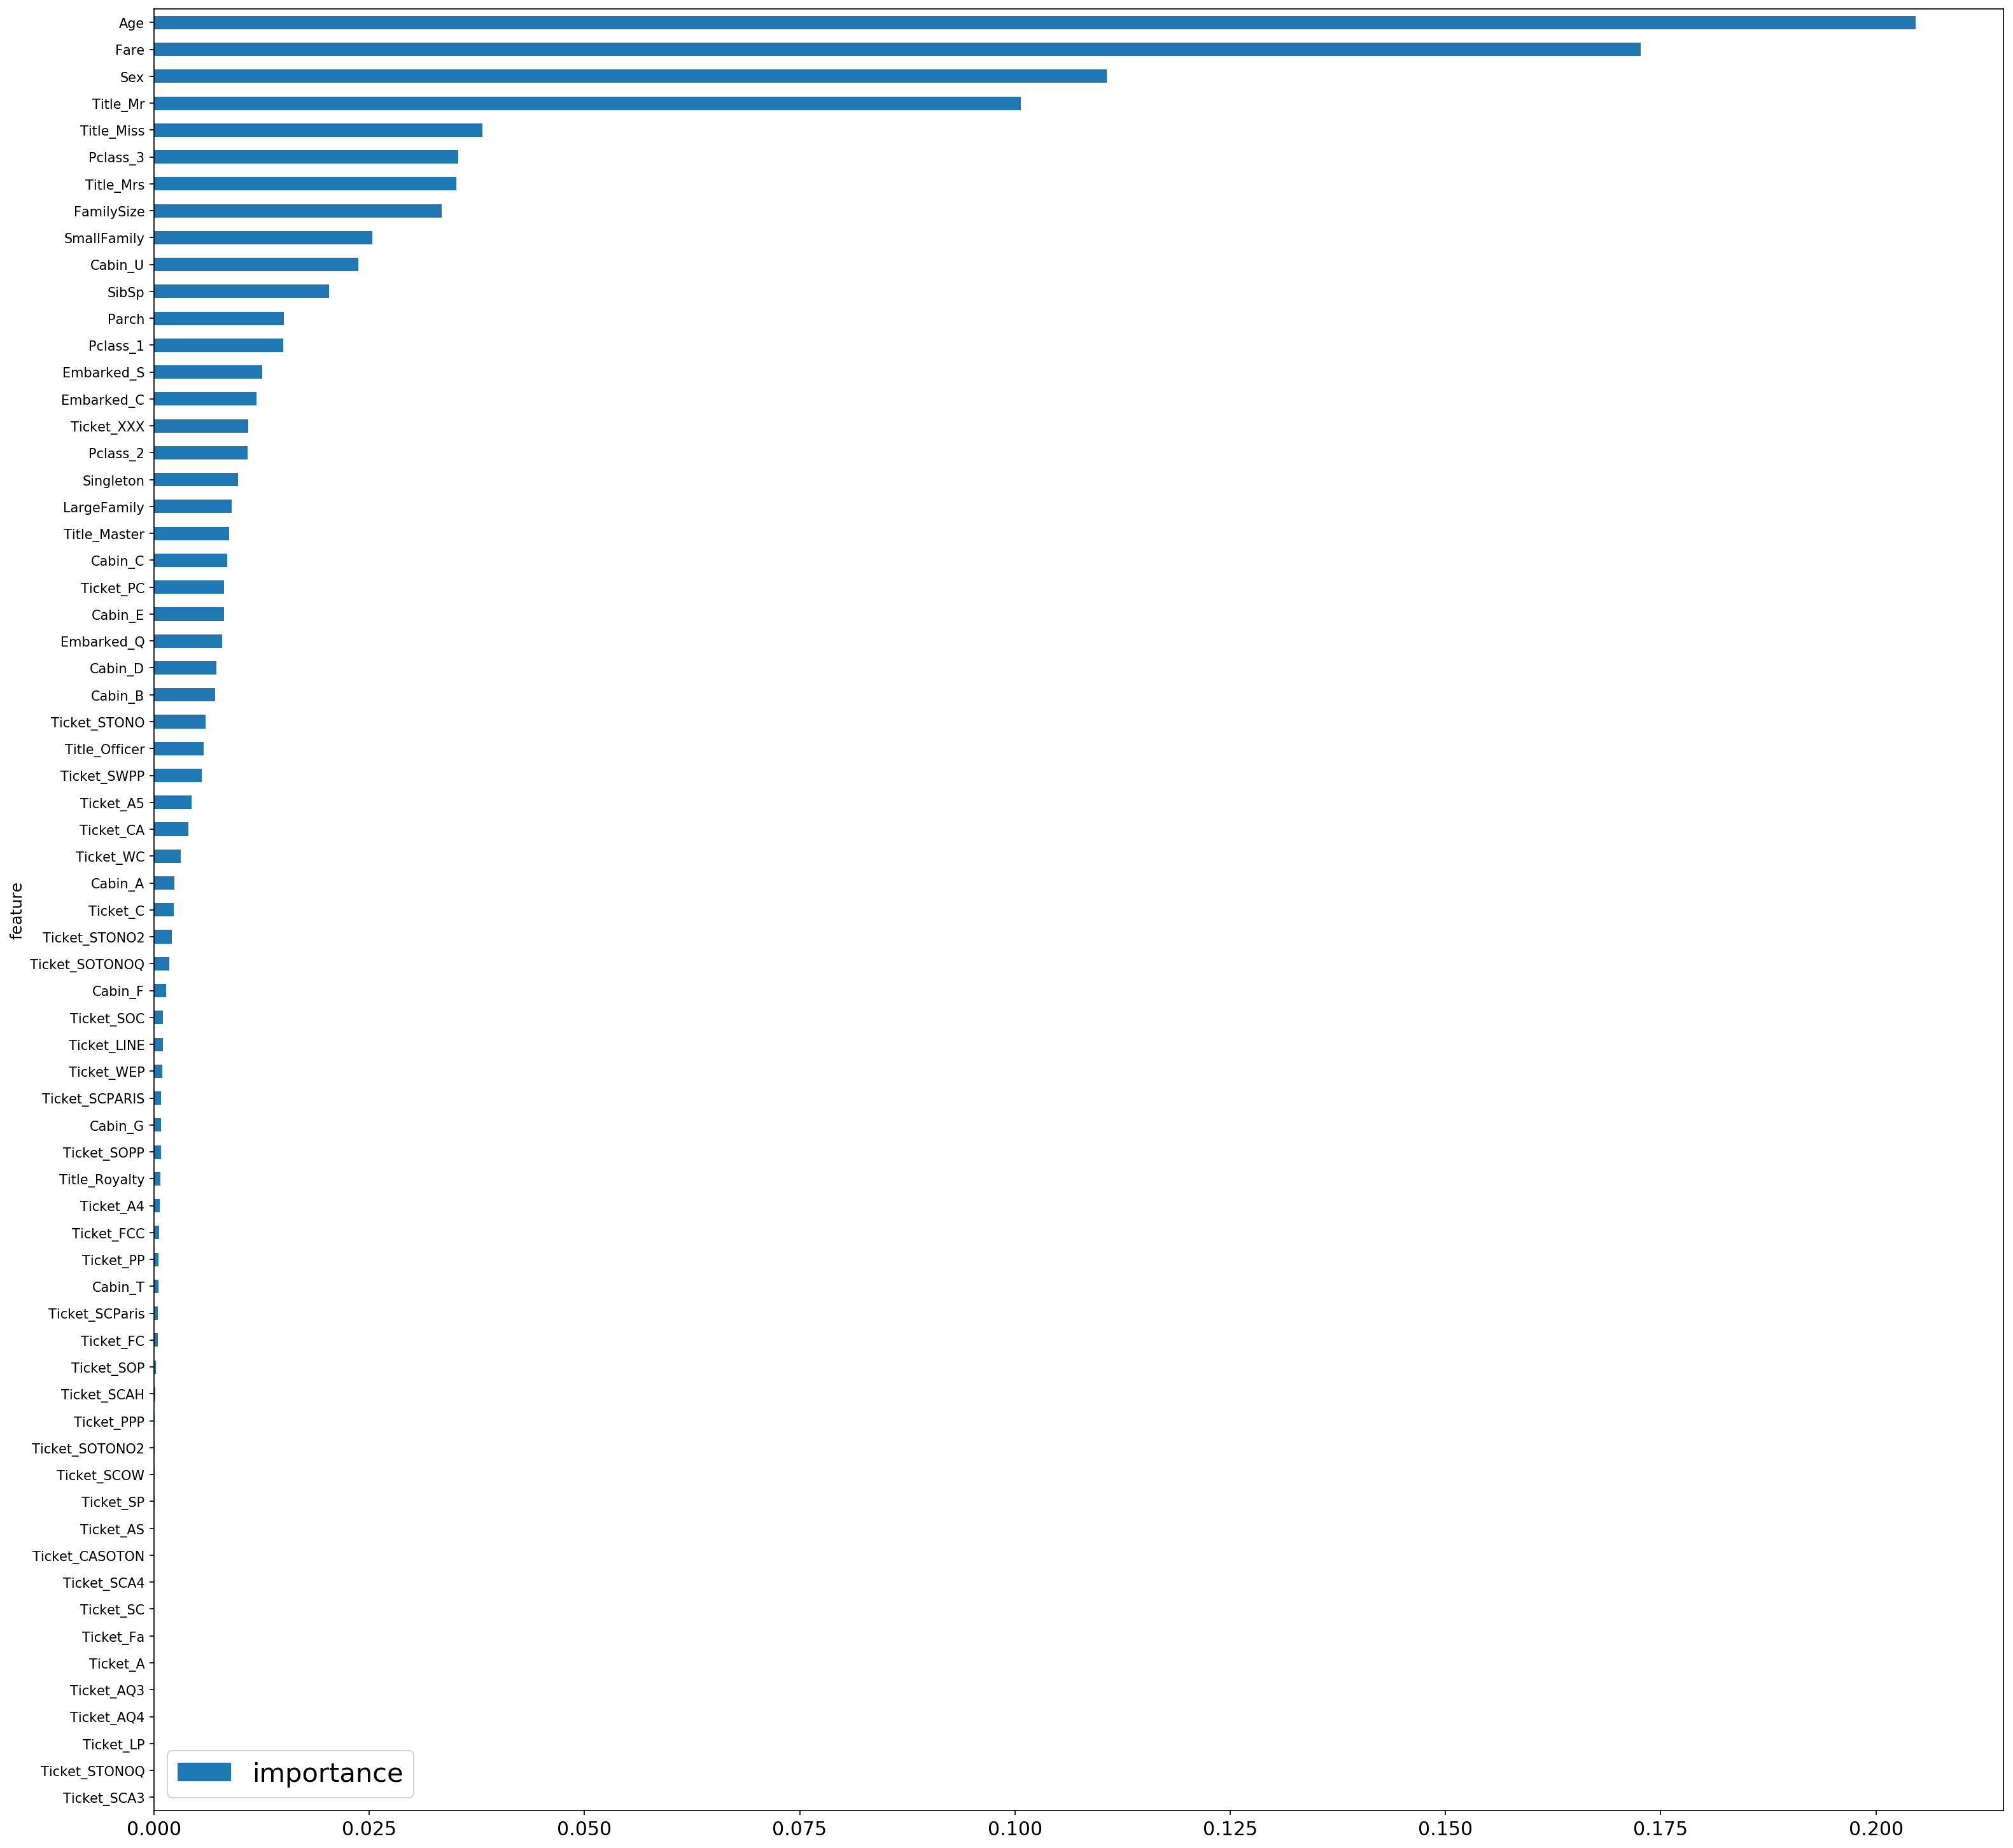

In [405]:
features.plot(kind='barh', figsize=(25, 25))

![energy](./images/article_1/8.png)

我们可以看到Title_Mr, Age, Fare, Sex等这些特征非常重要

我们可以做筛选

In [406]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
print (train_reduced.shape)

(891, 13)


In [407]:
test_reduced = model.transform(test)
print (test_reduced.shape)

(418, 13)


这里筛了13个（这个自己决定，我测试的话13个准确率比较高）

## 看一下不同模型的表现情况（逻辑回归，逻辑回归_交叉验证，随机森林，gboost）

In [408]:
logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]

In [409]:
for model in models:
    print ('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced, y=targets, scoring='accuracy')
    print ('CV score = {0}'.format(score))
    print ('****')

Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score = 0.8103383340656581
****
Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegressionCV'>
CV score = 0.8159500345238841
****
Cross-validation of : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score = 0.8204255853367648
****
Cross-validation of : <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV score = 0.8372481325717155
****


## 调参

我在这里使用随机森林模型。它可能不是执行此任务的最佳模型，但随机森林非常方便。但是，它们确实带有一些要调整的参数，以便为预测任务获得最佳模型。

In [410]:
# 如果你想看最佳参数 就把 run_gs设置为True 
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

### 可以用模型进行预测然后上传啦！

In [411]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('gridsearch_rf.csv', index=False)

# 四、Blending （模型融合）

In [412]:
trained_models = []
for model in models:
    model.fit(train, targets)
    trained_models.append(model)

predictions = []
for model in trained_models:
    predictions.append(model.predict_proba(test)[:, 1])

predictions_df = pd.DataFrame(predictions).T
predictions_df['out'] = predictions_df.mean(axis=1)
predictions_df['PassengerId'] = aux['PassengerId']
predictions_df['out'] = predictions_df['out'].map(lambda s: 1 if s >= 0.5 else 0)

predictions_df = predictions_df[['PassengerId', 'out']]
predictions_df.columns = ['PassengerId', 'Survived']

In [413]:
predictions_df.to_csv('blending_base_models.csv', index=False)

### 但是模型融合的准确率并不是很高，可能别的模型没有仔细的调参。
融合前0.79，融合后0.77（sad

### 目前先做到这，有想法在持续跟近。